In [1]:
import pandas as pd
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
data = pd.read_csv('mnist_train.csv')

In [2]:
print(data.head())

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]


In [3]:
labels = np.array(data.iloc[:,0])
x_train = np.array(data.iloc[:,1:])/255 

In [4]:
encoded_labels = []
for i in range(len(labels)):
  naked = [0,0,0,0,0,0,0,0,0,0]
  naked[labels[i]] = 1
  encoded_labels.append(naked)

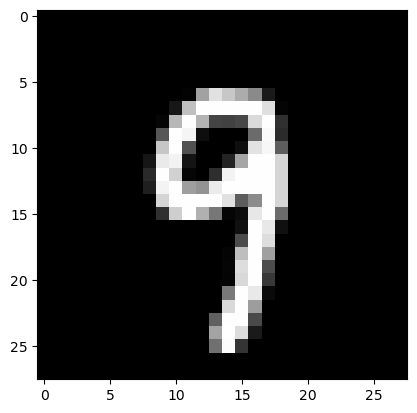

In [5]:
random_index = np.random.randint(0,40000)
img = x_train[random_index].reshape(28,28)
plt.imshow(img, cmap = "gray")

Step: 0 Average Error: 8.65349634586017
Step: 1000 Average Error: 1.4078442781955083
Step: 2000 Average Error: 0.8994713596911673
Step: 3000 Average Error: 0.8981118580695282
Step: 4000 Average Error: 0.8925457309844202
Step: 5000 Average Error: 0.8871282579112231
Step: 6000 Average Error: 0.8756908058130672
Step: 7000 Average Error: 0.8579770915498932
Step: 8000 Average Error: 0.807901453488346
Step: 9000 Average Error: 0.7543635396019502
Step: 10000 Average Error: 0.703582807123718
Step: 11000 Average Error: 0.6660197777711655
Step: 12000 Average Error: 0.6172877766701196
Step: 13000 Average Error: 0.5731739066785528
Step: 14000 Average Error: 0.5288698563662658
Step: 15000 Average Error: 0.4839990241278543
Step: 16000 Average Error: 0.4620511092702559
Step: 17000 Average Error: 0.447987954609553
Step: 18000 Average Error: 0.4284490986304092
Step: 19000 Average Error: 0.40326319622496803
Step: 20000 Average Error: 0.3652416013900684
Step: 21000 Average Error: 0.3782314274026036
Step:

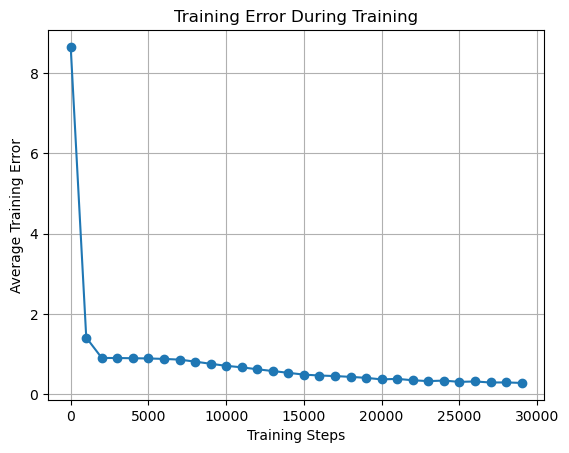

Final Test Accuracy: 87.54%


In [6]:

# -----------------------------
# Define a simple Deep Neural Network class
# -----------------------------
class DNN():
    def __init__(self, layers):
        """
        layers: list defining number of neurons in each layer
                e.g. [784, 1250, 10] for input, hidden, output
        """
        self.layers = layers
        self.weights = []
        # Randomly initialize weights (including bias term)
        for i in range(len(layers)-1):
            layers_weights = np.random.rand(layers[i+1], layers[i]+1)
            self.weights.append(layers_weights)

    def sigmoid(self, x):
        """Sigmoid activation function (scaled by 0.01 factor)."""
        return 1 / (1 + np.exp(-0.01 * x))

    def predict(self, data):
        """
        Forward pass through the network.
        data: input vector
        returns: output predictions
        """
        x_s = [data]
        for i in range(len(self.layers)-1):
            # Add bias input of 1
            x_s[-1] = np.concatenate((x_s[-1], [1]))
            z = np.dot(self.weights[i], x_s[i])
            x_s.append(self.sigmoid(z))
        return x_s[-1]

    def train(self, data, y_true):
        """
        Train the network on a single data sample using backpropagation.
        Returns squared error for monitoring.
        """
        # Forward pass
        x_s = [data]
        for i in range(len(self.layers)-1):
            x_s[-1] = np.concatenate((x_s[-1], [1]))
            z = np.dot(self.weights[i], x_s[i])
            x_s.append(self.sigmoid(z))

        # Compute error term for output layer
        psi = []
        for i in range(len(y_true)):
            output = x_s[-1][i]
            psi.append(-2 * (y_true[i] - output) * (output * (1 - output)))
        psi = np.array(psi).reshape(-1, 1)

        # Backpropagation: compute gradients
        gradients = []
        gradients.append(psi * x_s[-2])
        for i in range(len(self.layers) - 2, 0, -1):
            w = self.weights[i][:, :-1]
            x = x_s[i][:-1]
            term = w * x * (1 - x)
            term = np.transpose(term)
            psi = np.dot(term, psi).reshape(-1, 1)
            gradients.append(psi * x_s[i-1])

        # Update weights using gradient descent
        for i in range(len(gradients)):
            self.weights[i] -= 0.1 * gradients[-(i+1)]

        return sum((y_true - x_s[-1])**2)


# Initialize model
model = DNN([784, 1250, 10])

# -----------------------------
# Training Loop
# -----------------------------
error = deque(maxlen=1000)  # moving average window
train_errors = []
steps = []

for n in range(30000):
    index = np.random.randint(0, 59998)
    err = model.train(x_train[index], encoded_labels[index])
    error.append(err)

    if n % 1000 == 0:  # log progress every 1000 steps
        steps.append(n)
        train_errors.append(sum(error) / len(error))
        print("Step:", n, "Average Error:", train_errors[-1])

# -----------------------------
# Plot Training Error
# -----------------------------
plt.plot(steps, train_errors, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Average Training Error")
plt.title("Training Error During Training")
plt.grid(True)
# Save high-resolution figure for report
plt.savefig("training_error.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# Evaluate on Test Data
# -----------------------------
test_data = pd.read_csv('mnist_test.csv')
test_labels = np.array(test_data.iloc[:, 0])       # first column = labels
x_test = np.array(test_data.iloc[:, 1:]) / 255.0   # normalize pixel values

correct = 0
for i in range(len(test_data)):
    prediction = np.argmax(model.predict(x_test[i]))
    if prediction == test_labels[i]:
        correct += 1

percent_correct = correct / len(test_data) * 100
print("Final Test Accuracy: {:.2f}%".format(percent_correct))



Training with hidden layer size = 100
Step: 0, Avg Error: 3.23216766212044
Step: 1000, Avg Error: 1.132603734715612
Step: 2000, Avg Error: 0.9029965711829543
Step: 3000, Avg Error: 0.9018282859703544
Step: 4000, Avg Error: 0.9017130350046986
Step: 5000, Avg Error: 0.9015819068711761
Step: 6000, Avg Error: 0.9015152230626109
Step: 7000, Avg Error: 0.9014509419309578
Step: 8000, Avg Error: 0.9006923715379478
Step: 9000, Avg Error: 0.9015815224499996
Final Test Accuracy with 100 hidden neurons: 11.35%

Training with hidden layer size = 500
Step: 0, Avg Error: 6.394145141534513
Step: 1000, Avg Error: 1.0652682758453027
Step: 2000, Avg Error: 0.9017148157100133
Step: 3000, Avg Error: 0.8986106684357515
Step: 4000, Avg Error: 0.8987712172271042
Step: 5000, Avg Error: 0.8938781502932079
Step: 6000, Avg Error: 0.8905645196337861
Step: 7000, Avg Error: 0.8778181618370668
Step: 8000, Avg Error: 0.8685270969223648
Step: 9000, Avg Error: 0.8362680031703813
Final Test Accuracy with 500 hidden neur

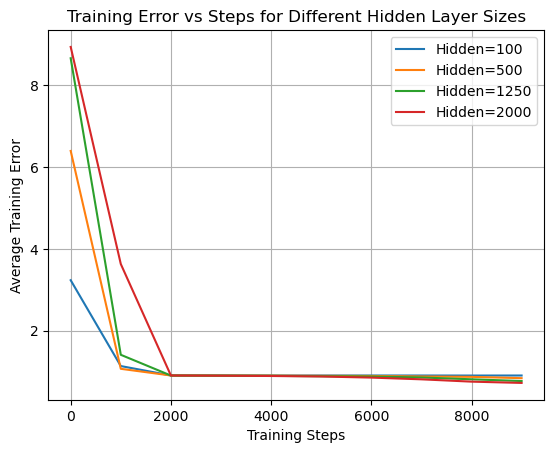

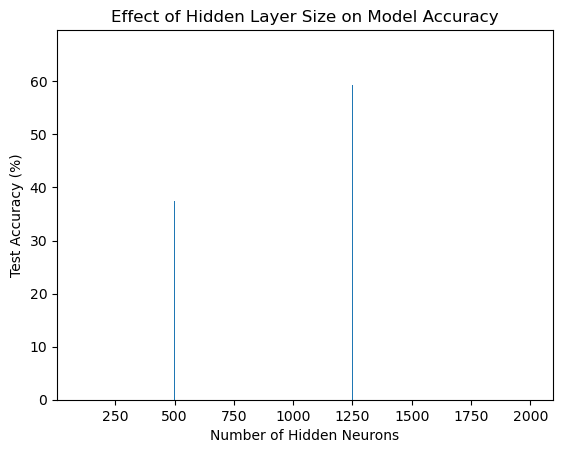

In [7]:

# Define Deep Neural Network Class
# -----------------------------
class DNN():
    def __init__(self, layers):
        """
        layers: list with number of neurons in each layer
                e.g., [784, 1250, 10]
        """
        self.layers = layers
        self.weights = []
        # Random weight initialization (with bias included)
        for i in range(len(layers)-1):
            layers_weights = np.random.rand(layers[i+1], layers[i]+1)
            self.weights.append(layers_weights)

    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-0.01 * x))

    def predict(self, data):
        """Forward pass through the network"""
        x_s = [data]
        for i in range(len(self.layers)-1):
            # Add bias = 1
            x_s[-1] = np.concatenate((x_s[-1], [1]))
            z = np.dot(self.weights[i], x_s[i])
            x_s.append(self.sigmoid(z))
        return x_s[-1]

    def train(self, data, y_true):
        """One training step: forward + backpropagation + weight update"""
        # Forward pass
        x_s = [data]
        for i in range(len(self.layers)-1):
            x_s[-1] = np.concatenate((x_s[-1], [1]))
            z = np.dot(self.weights[i], x_s[i])
            x_s.append(self.sigmoid(z))

        # Error term for output layer
        psi = []
        for i in range(len(y_true)):
            output = x_s[-1][i]
            psi.append(-2*(y_true[i] - output) * (output * (1 - output)))
        psi = np.array(psi).reshape(-1, 1)

        # Backpropagation
        gradients = []
        gradients.append(psi * x_s[-2])
        for i in range(len(self.layers) - 2, 0, -1):
            w = self.weights[i][:, :-1]
            x = x_s[i][:-1]
            term = w * x * (1 - x)
            term = np.transpose(term)
            psi = np.dot(term, psi).reshape(-1, 1)
            gradients.append(psi * x_s[i-1])

        # Update weights
        for i in range(len(gradients)):
            self.weights[i] -= 0.1 * gradients[-(i+1)]

        return sum((y_true - x_s[-1])**2)


# -----------------------------
# Load Data
# -----------------------------
# Training data (already loaded in your environment)
# x_train: shape (60000, 784), encoded_labels: shape (60000, 10)
# Test data
test_data = pd.read_csv('mnist_test.csv')
test_labels = np.array(test_data.iloc[:, 0])
x_test = np.array(test_data.iloc[:, 1:]) / 255.0

# -----------------------------
# Experiment with Different Hidden Layer Sizes
# -----------------------------
hidden_sizes = [100, 500, 1250, 2000]
results = {}

for hidden in hidden_sizes:
    print(f"\nTraining with hidden layer size = {hidden}")
    model = DNN([784, hidden, 10])
    error = deque(maxlen=1000)
    train_errors = []
    steps = []

    # Training loop
    for n in range(10000):  # shorter for testing, can increase
        index = np.random.randint(0, 59998)
        err = model.train(x_train[index], encoded_labels[index])
        error.append(err)

        if n % 1000 == 0:
            steps.append(n)
            train_errors.append(sum(error) / len(error))
            print(f"Step: {n}, Avg Error: {train_errors[-1]}")

    # Plot training error for this hidden size
    plt.plot(steps, train_errors, label=f"Hidden={hidden}")

    # Evaluate accuracy on test set
    correct = 0
    for i in range(len(test_data)):
        prediction = np.argmax(model.predict(x_test[i]))
        if prediction == test_labels[i]:
            correct += 1
    accuracy = correct / len(test_data) * 100
    results[hidden] = accuracy
    print(f"Final Test Accuracy with {hidden} hidden neurons: {accuracy:.2f}%")

# -----------------------------
# Plot Training Error Comparison
# -----------------------------
plt.xlabel("Training Steps")
plt.ylabel("Average Training Error")
plt.title("Training Error vs Steps for Different Hidden Layer Sizes")
plt.legend()
plt.grid(True)
plt.savefig("training_error_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# Plot Accuracy vs Hidden Size
# -----------------------------
plt.bar(results.keys(), results.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Test Accuracy (%)")
plt.title("Effect of Hidden Layer Size on Model Accuracy")
plt.savefig("accuracy_vs_hidden_size.png", dpi=300, bbox_inches='tight')
plt.show()


Saved: perceptron_all_100.png


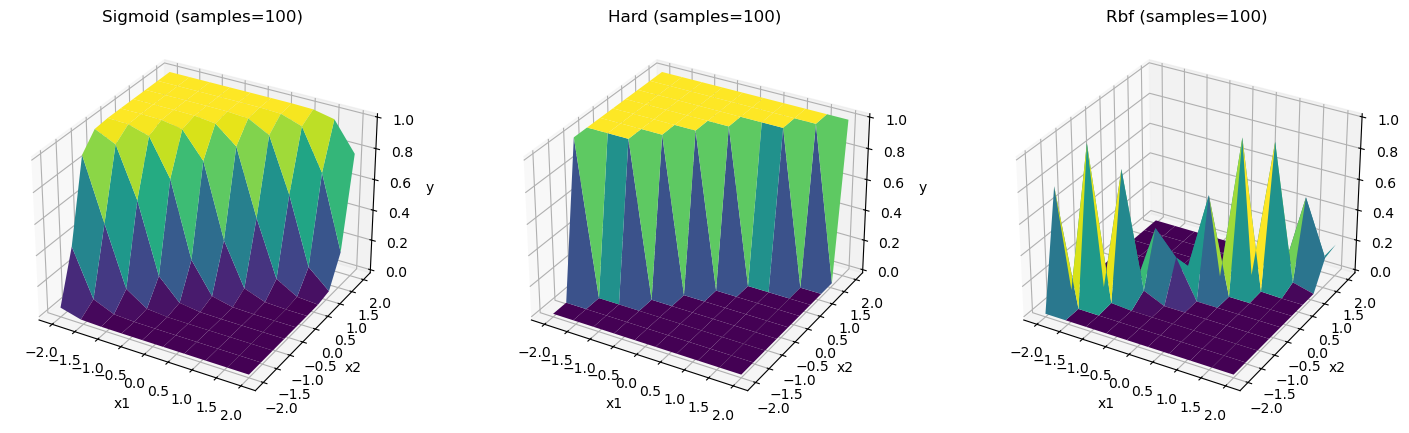

Saved: perceptron_all_5000.png


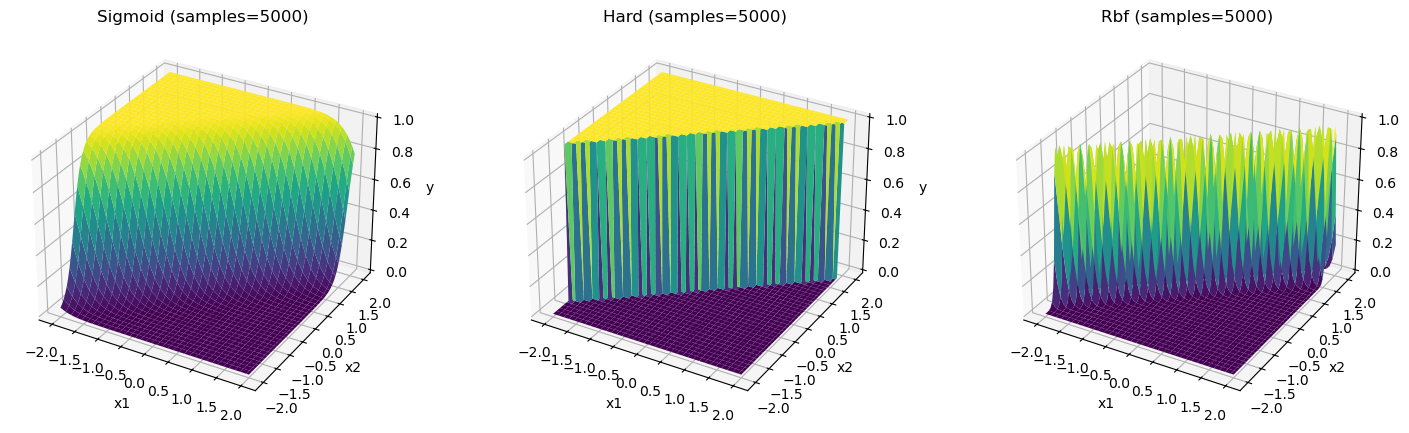

Saved: perceptron_all_10000.png


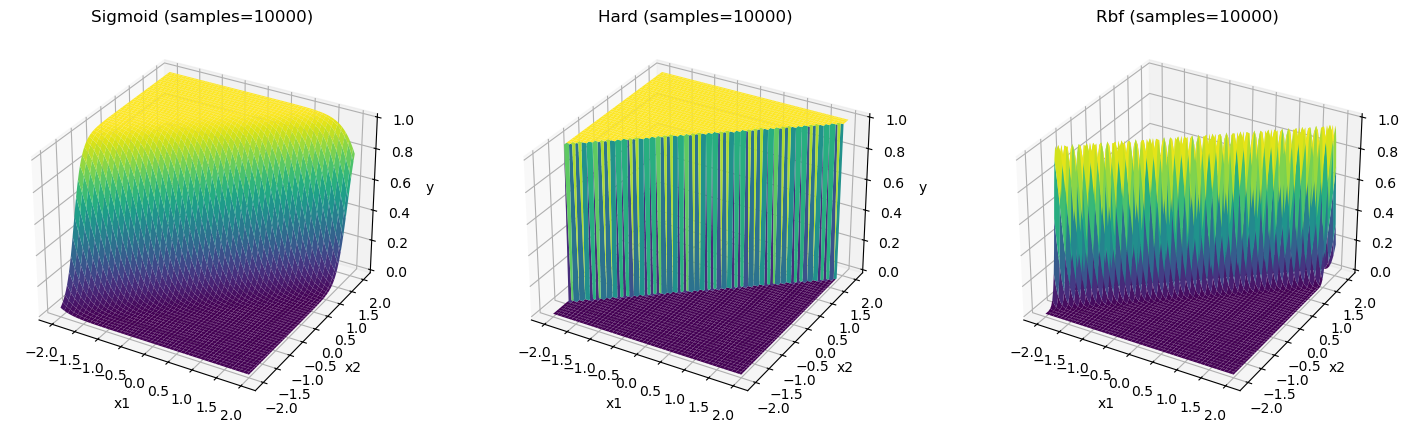

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ----------------------------------------
# Define activation functions
# ----------------------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def hard_limit(z):
    return np.where(z >= 0, 1, 0)

def rbf(z):
    return np.exp(-z**2)

# ----------------------------------------
# Perceptron model
# ----------------------------------------
def perceptron(x1, x2, activation="sigmoid"):
    z = -4.79 * x1 + 5.90 * x2 - 0.93
    if activation == "sigmoid":
        return sigmoid(z)
    elif activation == "hard":
        return hard_limit(z)
    elif activation == "rbf":
        return rbf(z)
    else:
        raise ValueError("Unknown activation function")

# ----------------------------------------
# Plot all activations in one figure for given sample size
# ----------------------------------------
def plot_all_activations(sample_size):
    activations = ["sigmoid", "hard", "rbf"]
    fig = plt.figure(figsize=(18, 5))
    
    x1 = np.linspace(-2, 2, int(np.sqrt(sample_size)))
    x2 = np.linspace(-2, 2, int(np.sqrt(sample_size)))
    X1, X2 = np.meshgrid(x1, x2)

    for i, activation in enumerate(activations, 1):
        Y = perceptron(X1, X2, activation)
        ax = fig.add_subplot(1, 3, i, projection="3d")
        ax.plot_surface(X1, X2, Y, cmap="viridis")
        ax.set_title(f"{activation.capitalize()} (samples={sample_size})")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("y")

    # Save as high-resolution PNG
    filename = f"perceptron_all_{sample_size}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")
    plt.show()

# ----------------------------------------
# Run for all sample sizes
# ----------------------------------------
for size in [100, 5000, 10000]:
    plot_all_activations(size)
